In [ ]:
!pip3 install torch torchvision torchaudio

In [ ]:
!pip show torch

# question 1

## (1)
Suppose we have a vocabulary {buy, bought, girl, woman, word, words}, please represent each word using the one-hot encoding.  

**answer**  
Suppose elements in the vector represent whether the word is {buy, bought, girl, woman, word, words} respectively in order, then vector of each word is as follow:  
- buy: [1,0,0,0,0,0]
- bought: [0,1,0,0,0,0]
- girl: [0,0,1,0,0,0]
- woman: [0,0,0,1,0,0]
- word: [0,0,0,0,1,0]
- words: [0,0,0,0,0,1]

## (2)
Combined with the previous question, what are the drawbacks of doing so? Answer at least two reasons.

**answer**  
- **Sparsity**: each additional word will add one more dimension, but such many dimensions don't really have enriched information, which is not good for optimization 
- **high computational cost**: high dimension will result in high computational cost
- **Expandability**: if the size of vocabulary will grow, we need to adjust all existing vectors.

## (3)
Given a vocabulary {girl, woman, boy, man}, consider a computation unit with 4 nodes when we use the one-hot
approach to encode the word “girl”:

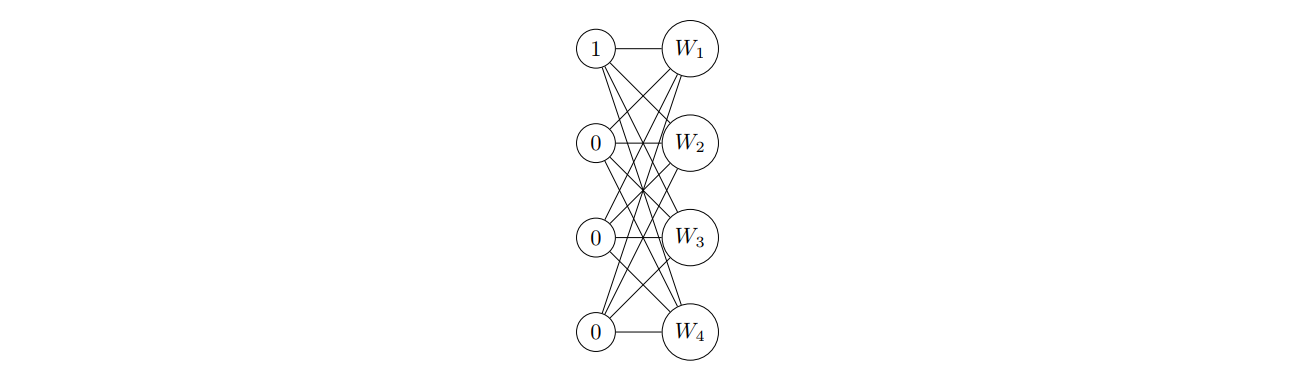

In this case, we need 4 × 4 nodes to maintain the computation unit. Do you have any methods that could better
represent the word in this vocabulary and reduce the amount of nodes to 2 × 4 ? Please give the solution and
explanations.

**answer**  
We can use `binary encoding` to solve the problem, i.e. represent {girl, woman, boy, man} via `[0,0],[0,1],[1,0],[1,1]`  
Binary encoding is more memory-efficient because it uses fewer features than one-hot encoding. One-hot encoding needs 4 features to represent 4 categories, while binary encoding only needs 2. And binary encoding can also reduce the curse of high dimensionality.  
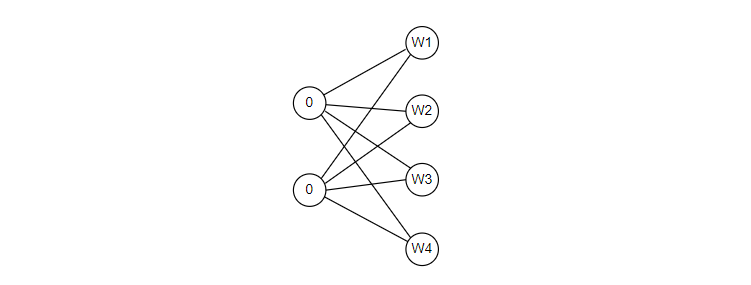

# question2

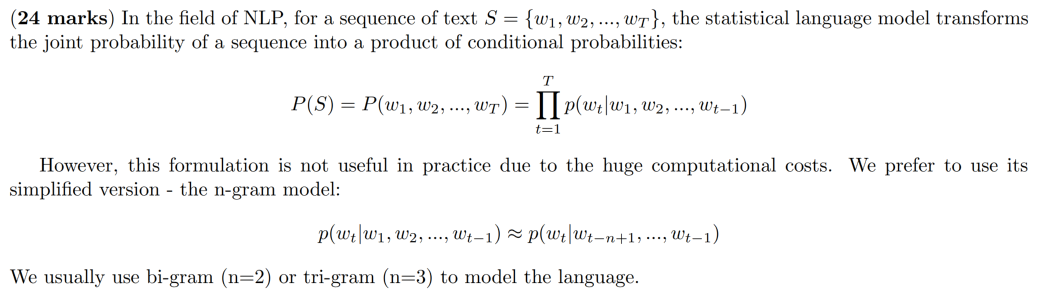

## (1)
Given the text“the physical meanings of both the complex-valued entity and word embeddings is unknown”,
please list all the bi-gram and tri-gram forms that contains the word “meanings” or “embeddings”. 

**answer**  
`bi-gram of "meanings"` :"physical meanings","meanings of"  
`tri-gram of "meanings"`:"the physical meanings","physical meanings of","meanings of both"   
  
`bi-gram of "embeddings"`:"word embeddings","embeddings is"  
`tri-gram of "embeddings"`:"and word embeddings","word embeddings is","embeddings is unknown" 

## (2)
What are the disadvantages of n-gram model? 

**answer**  
- **sparsity problem**:if context words are not in the corpus, or the target word is not in the corpus, n-gram will not work well  
- **storage problem**: need to store all n-gram which will occupy a lot of spaces
- **dependency problem**: the target word may depend on words which will appear in the sentence later


## (3)
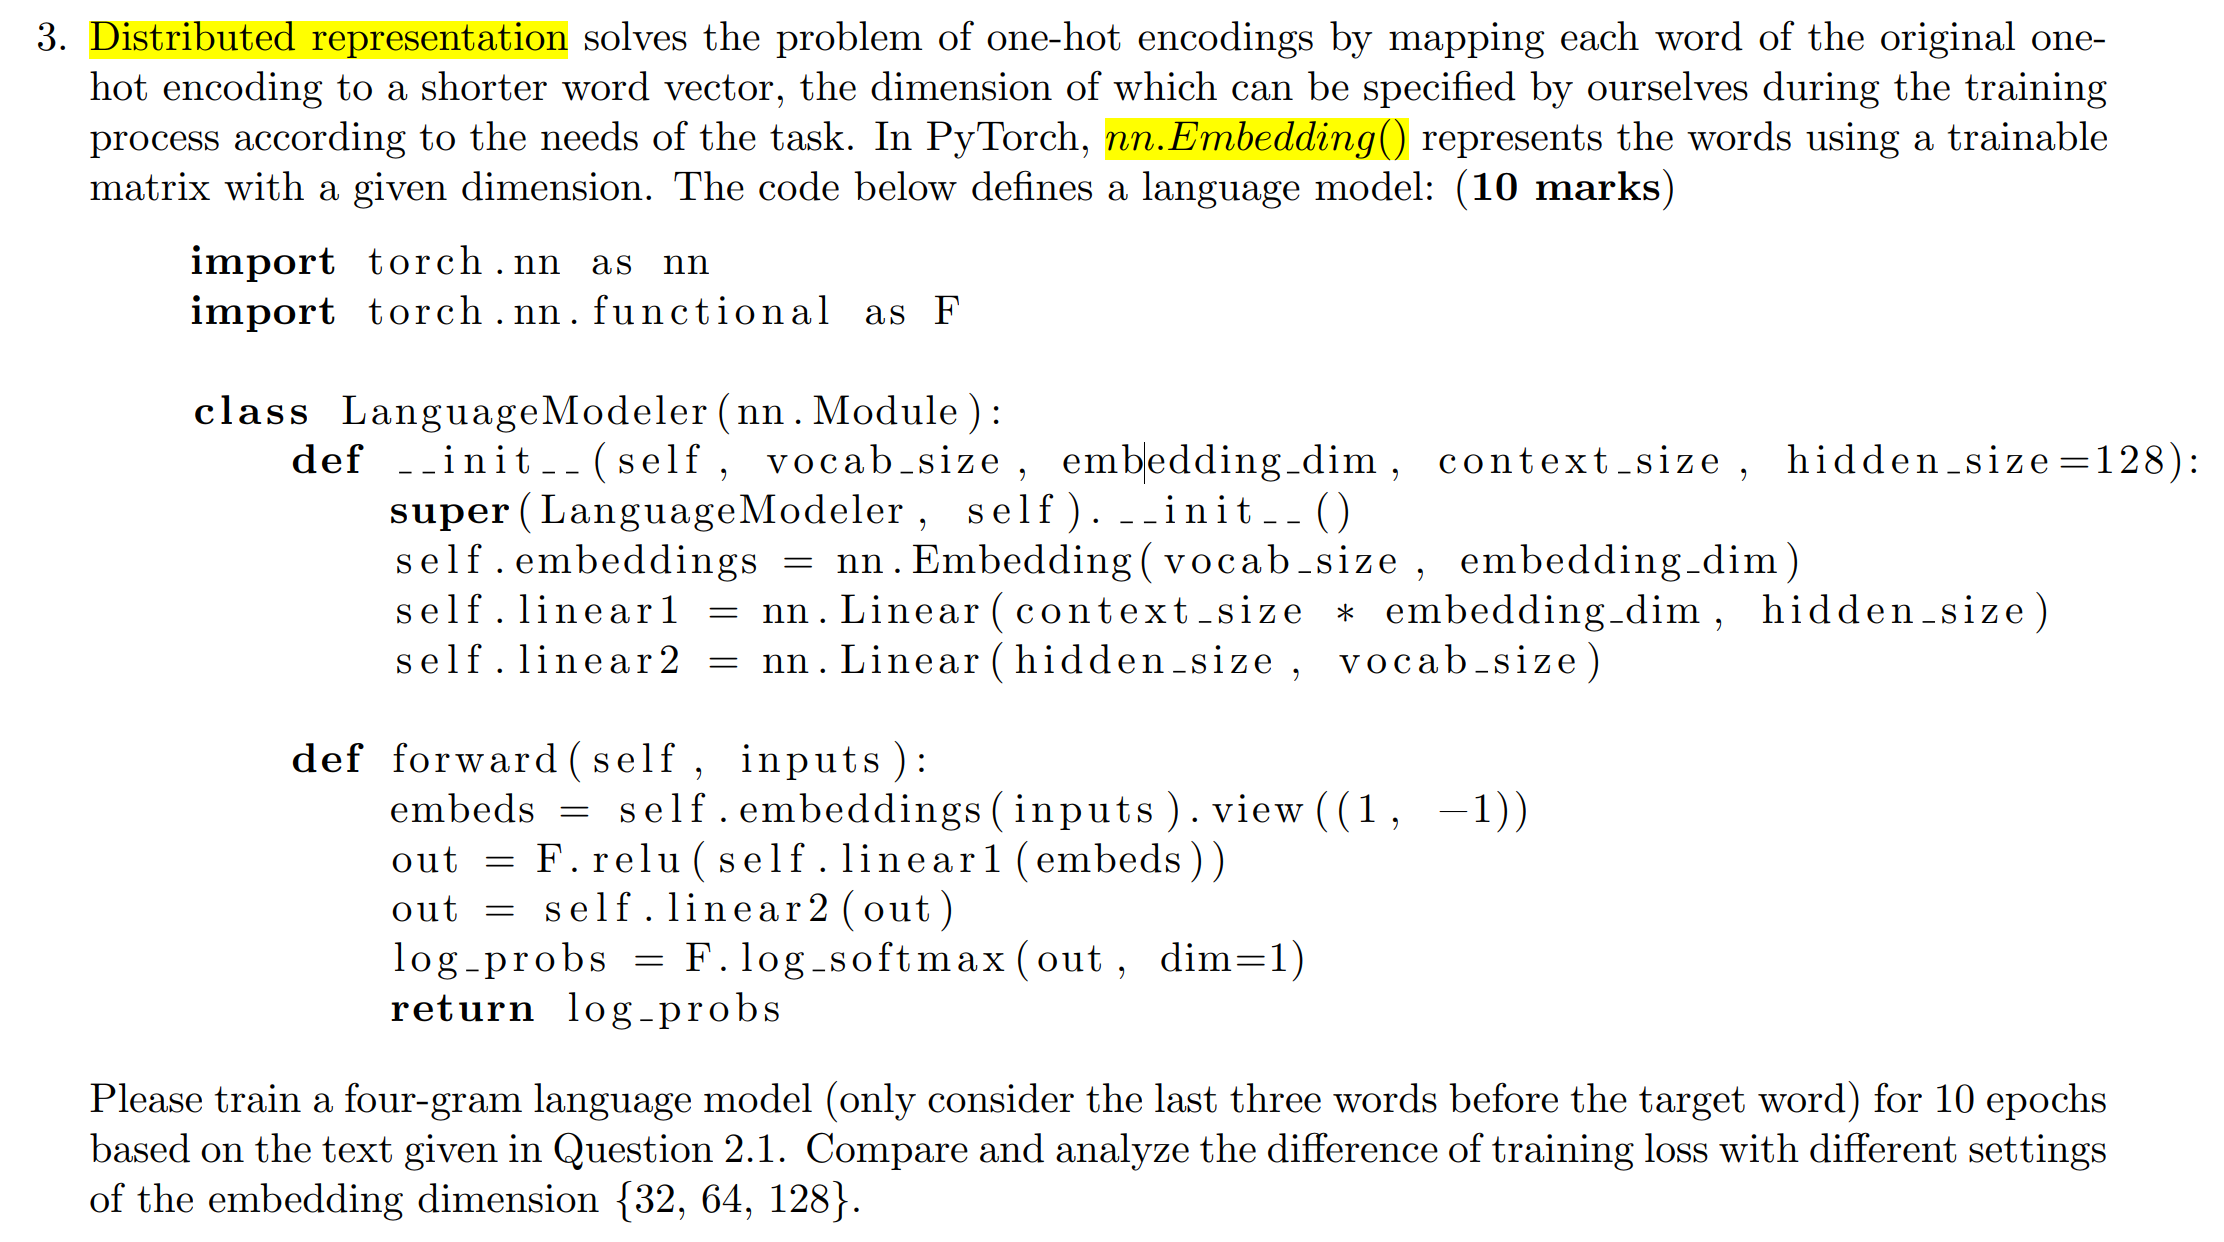

**answer**  
Following code is implementation of four-gram language model.  
According to the final result, `embedding dimension of 128 produced the smallest loss`, but it doesn't mean higher embedding dimension always performs better. Because it will only make training set fit better, but may have problem of `overfitting` which will make loss of test set be large.


In [287]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
print("PyTorch version: ", torch.__version__)
print("GPU support: ", torch.cuda.is_available())
print("Available devices count: ", torch.cuda.device_count())

PyTorch version:  1.13.1+cpu
GPU support:  False
Available devices count:  0


In [288]:
test_sentence ='the physical meanings of both the complex-valued entity and word embeddings is unknown'.split()

In [289]:
four_grams = [([test_sentence[i], test_sentence[i + 1], test_sentence[i + 2]], test_sentence[i + 3])
            for i in range(len(test_sentence) - 3)]
vocab = set(test_sentence)

word_to_ix = {word: i for i, word in enumerate(vocab)}
ix_to_word = {i: word for i, word in enumerate(vocab)}

In [290]:
class LanguageModeler (nn.Module):
    def __init__ (self,vocab_size,embedding_dim,context_size,hidden_size=128):
        super(LanguageModeler,self).__init__( )
        self.embeddings = nn.Embedding(vocab_size,embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim,hidden_size)
        self.linear2 = nn.Linear(hidden_size,vocab_size)
    def forward(self,inputs) :
        embeds = self.embeddings(inputs).view((1,-1)) # equal to reshape
#         print("input:",input)
#         print("embeds:",embeds)
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out,dim=1)
        return log_probs

In [291]:
embedding_dim = [32,64,128]
loss_dict={}
context_size = 3

for embed_dim in embedding_dim:
    print("embedding dimension:",embed_dim)
    model = LanguageModeler(len(vocab), embed_dim, context_size)
    losses = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001)

    for epoch in range(10):
        total_loss = torch.Tensor([0])
        for context, target in four_grams:
            # Prepare inputs
            context_idxs = [word_to_ix[w] for w in context]
            context_var = autograd.Variable(torch.LongTensor(context_idxs))
            #print(context, target,context_idxs,context_var)

            # zero out the gradients from the old instance
            model.zero_grad()

            # forward pass, getting log probabilities over next word
            log_probs = model(context_var)
            #print(log_probs,embedd)

            # Compute your loss function
            loss = criterion(log_probs, autograd.Variable(torch.LongTensor([word_to_ix[target]])))
            #print(log_probs, autograd.Variable(torch.LongTensor([word_to_ix[target]])))

            # backward and update the gradient
            loss.backward()
            optimizer.step()

            total_loss += loss.data
        losses.append(total_loss)
        print("total loss:",total_loss[0])
    loss_dict[embed_dim]=total_loss
    
print("results compare:",loss_dict)

embedding dimension: 32
total loss: tensor(25.8871)
total loss: tensor(25.5849)
total loss: tensor(25.2868)
total loss: tensor(24.9916)
total loss: tensor(24.6992)
total loss: tensor(24.4092)
total loss: tensor(24.1213)
total loss: tensor(23.8359)
total loss: tensor(23.5534)
total loss: tensor(23.2730)
embedding dimension: 64
total loss: tensor(25.4528)
total loss: tensor(24.9872)
total loss: tensor(24.5283)
total loss: tensor(24.0768)
total loss: tensor(23.6335)
total loss: tensor(23.1969)
total loss: tensor(22.7651)
total loss: tensor(22.3377)
total loss: tensor(21.9172)
total loss: tensor(21.5015)
embedding dimension: 128
total loss: tensor(25.0708)
total loss: tensor(24.3373)
total loss: tensor(23.6248)
total loss: tensor(22.9289)
total loss: tensor(22.2505)
total loss: tensor(21.5946)
total loss: tensor(20.9562)
total loss: tensor(20.3390)
total loss: tensor(19.7355)
total loss: tensor(19.1499)
results compare: {32: tensor([23.2730]), 64: tensor([21.5015]), 128: tensor([19.1499])}

# question 3
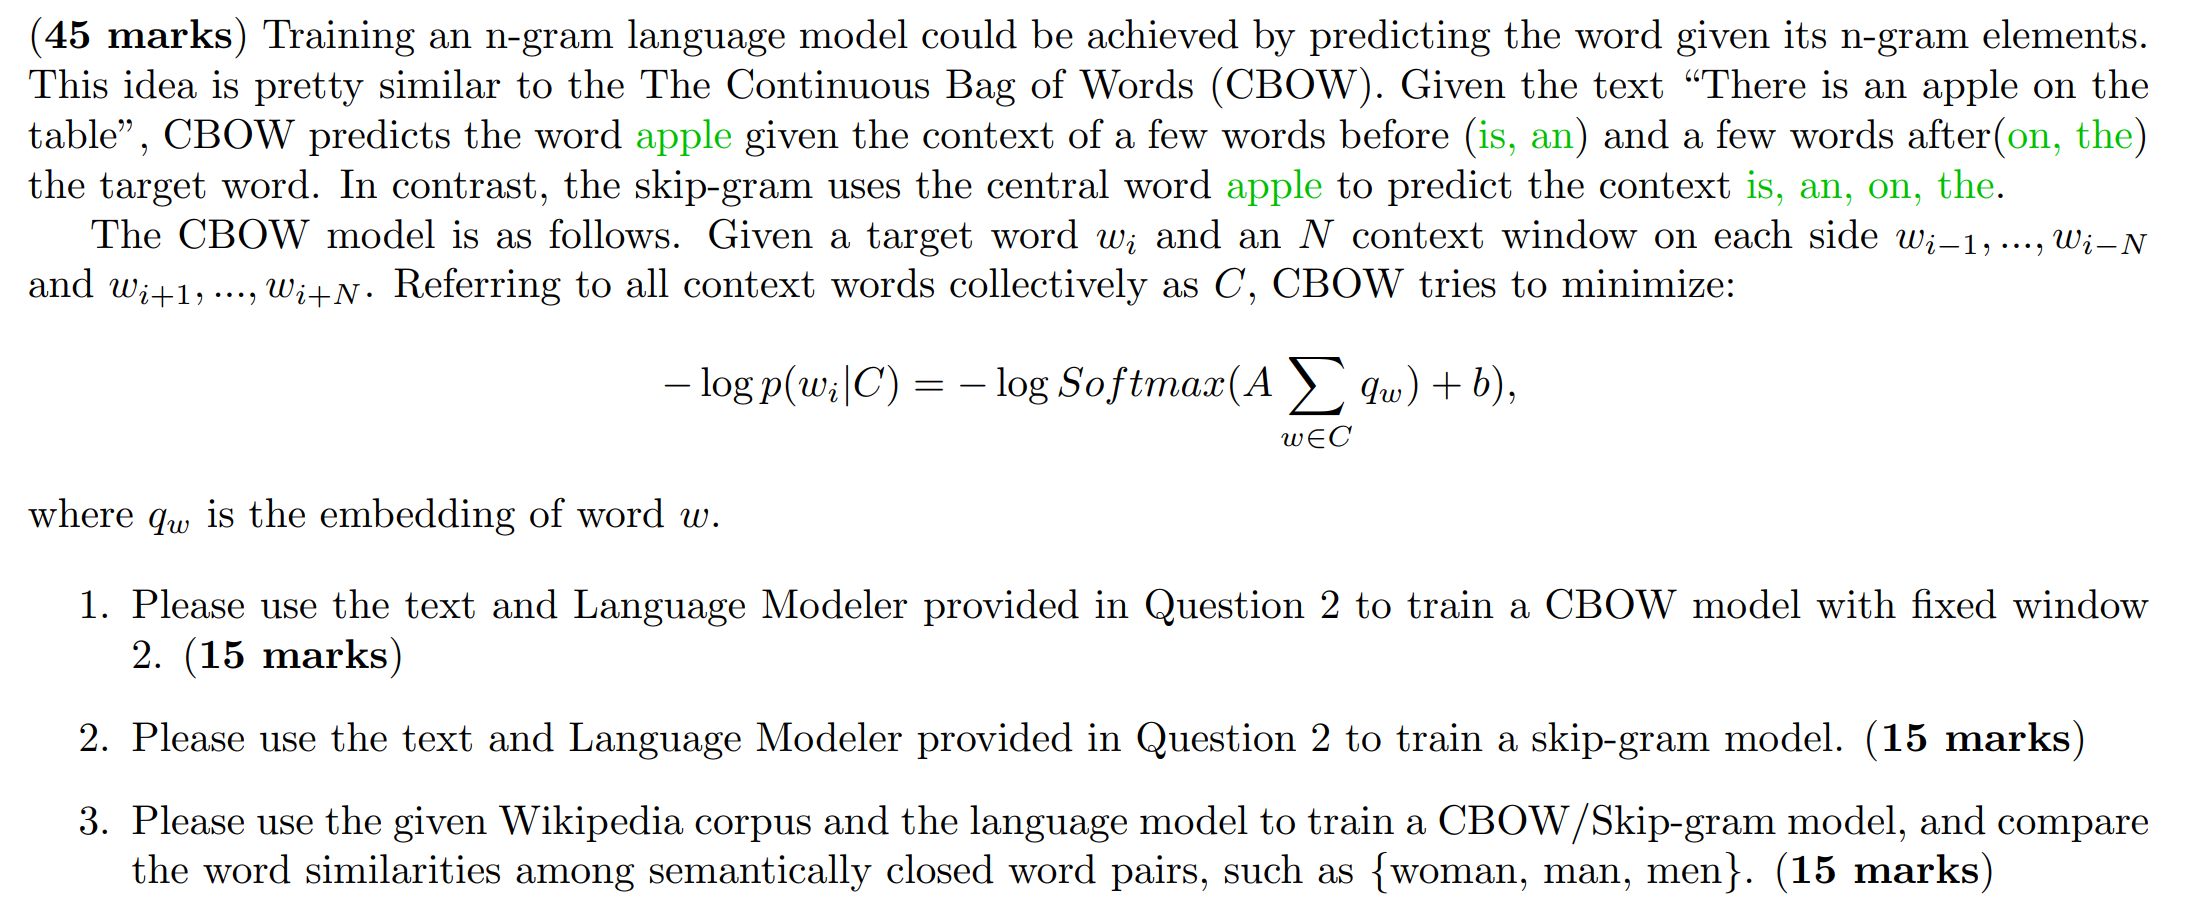

## CBOW

**answer**

In [292]:
cbow_window = [([test_sentence[i-2],test_sentence[i-1], test_sentence[i + 1], test_sentence[i + 2]], test_sentence[i])
            for i in range(2,len(test_sentence) - 2)]
# vocab = set(test_sentence)

# word_to_ix = {word: i for i, word in enumerate(vocab)}
# ix_to_word = {i: word for i, word in enumerate(vocab)}

In [312]:
embedding_dim = 32
context_size = 4
# model
model = LanguageModeler(len(vocab), embedding_dim,context_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)



for epoch in range(10):
    total_loss = torch.Tensor([0])
    for context, target in cbow_window:
        # Prepare inputs
        context_idxs = [word_to_ix[w] for w in context]
        context_var = autograd.Variable(torch.LongTensor(context_idxs))
        
        #print(context, target,context_idxs,context_var)

        # zero out the gradients from the old instance
        model.zero_grad()

        # forward pass, getting log probabilities over next word
        log_probs = model(context_var)
        # print(log_probs,autograd.Variable(torch.LongTensor([word_to_ix[target]])))

        # Compute your loss function
        loss = criterion(log_probs, autograd.Variable(torch.LongTensor([word_to_ix[target]])))
        #print(log_probs, autograd.Variable(torch.LongTensor([word_to_ix[target]])))

        # backward and update the gradient
        loss.backward()
        optimizer.step()

        total_loss += loss.data
        losses.append(total_loss)
        #if epoch % 100 == 0:
    print("total loss:",total_loss[0])


total loss: tensor(22.8259)
total loss: tensor(22.4979)
total loss: tensor(22.1738)
total loss: tensor(21.8535)
total loss: tensor(21.5384)
total loss: tensor(21.2269)
total loss: tensor(20.9194)
total loss: tensor(20.6160)
total loss: tensor(20.3157)
total loss: tensor(20.0181)


## skip-gram

In [315]:
WINDOWS = 2
pairs = []

for center_word_index in range(len(test_sentence)):
    center_word_ix = word_to_ix[test_sentence[center_word_index]]
    for win in range(-WINDOWS, WINDOWS+1):
        contenx_word_index = center_word_index + win
        if 0 <= contenx_word_index <= len(test_sentence)-1 and contenx_word_index != center_word_index:
            context_word_ix = word_to_ix[test_sentence[contenx_word_index]]
            pairs.append((center_word_ix, context_word_ix))


In [327]:
embedding_dim = 32
context_size = 1
voc_size=len(vocab)
# model
model = LanguageModeler(voc_size, embedding_dim,context_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# def get_onehot_vector(ix):
#     one_hot_vec = torch.zeros(voc_size).float()
#     one_hot_vec[ix] = 1.0
#     return one_hot_vec

for epoch in range(10):
    total_loss = torch.Tensor([0])
    for center_ix,context_ix in pairs:
        # Prepare inputs
        context_idxs = center_ix
        context_var = autograd.Variable(torch.LongTensor(np.array(context_idxs,dtype = np.float32)))
#         print(context, target,context_idxs,context_var)

        # zero out the gradients from the old instance
        model.zero_grad()

        # forward pass, getting log probabilities over next word
        log_probs = model(context_var)

        y=autograd.Variable(torch.LongTensor(np.array(center_ix,dtype = np.float32).reshape(1)))
        # Compute your loss function
        loss = criterion(log_probs, y)

        # backward and update the gradient
        loss.backward()
        optimizer.step()

        total_loss += loss.data
    losses.append(total_loss)
        #if epoch % 100 == 0:
    print("total loss:",total_loss[0])        


total loss: tensor(113.2188)
total loss: tensor(109.0557)
total loss: tensor(105.0173)
total loss: tensor(101.0926)
total loss: tensor(97.2768)
total loss: tensor(93.5735)
total loss: tensor(89.9788)
total loss: tensor(86.4918)
total loss: tensor(83.1178)
total loss: tensor(79.8567)


## CBOW on Wiki

**the training process is too long, didn't finish the training, only finished the implementation code**

### data load

In [ ]:
!pip install datasets transformers
!pip show transformers

In [255]:
#import wiki
from datasets import load_dataset
wiki_data_all = load_dataset('wikitext', 'wikitext-2-raw-v1')
print(wiki_data_all)
print(wiki_data_all["train"][3])
print(wiki_data_all['train'].features.items())

Found cached dataset wikitext (C:/Users/Heimer/.cache/huggingface/datasets/wikitext/wikitext-2-raw-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['text'],
        num_rows: 36718
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3760
    })
})
{'text': ' Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " Calamaty Raven " . \n'}
dict_items([('text', 

In [256]:
# extract part of wiki to train model to make it faster
wiki_data = wiki_data_all["train"]["text"]#[:10000]

In [59]:
# check dataset
from datasets import ClassLabel
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

show_random_elements(wiki_data["train"])

,text
0,Desmond Llewelyn as Q : Head of MI6 technical department . \n
1,"The opening of the following game between two world @-@ class players , another Symmetrical English , took a similar course : \n"
2,
3,"During the next few weeks , the pair began a losing streak , mainly caused by Hurricane 's on @-@ screen injuries . During the October 17 episode of Raw , The Hurricane was assaulted by Kurt Angle at the request of Vince McMahon . After the beating , footage was shown of The Hurricane ripping off his mask and striking Rosey because he did not help him fend off Angle . The next week , The Hurricane no @-@ showed a World Tag Team Title match , leaving Rosey to face the champions alone . During the match , The Hurricane ( out of costume ) appeared at the top of the entrance ramp , reverting to his real name , Gregory Helms , and watched as Rosey was double teamed and defeated . After the match , Helms announced that he was fed up with being funny for the crowd , and that he was sick of carrying Rosey as a tag team partner . This turned him into a heel in the process . On the November 7 episode of Raw , Helms and Rosey faced off in a singles match , which Helms won . Subsequently , Helms wrestled mostly on Raw 's sister show , Heat . On the January 2 , 2006 episode of Raw Helms confronted Jerry Lawler over jokes that Lawler had been making at Helms ' expense , and Lawler said that when Helms was The Hurricane , he was entertaining and called Helms a joke . Helms responded by slapping Lawler , who hit Helms back . This confrontation led to Lawler defeating Helms in a match at New Year 's Revolution . \n"
4,
5,"→ → Asomtavruli letters ო ( oni ) and ჳ ( vie ) . A ligature of these letters produced a new letter in Nuskhuri , უ uni . \n"
6,"Experienced condom users are significantly less likely to have a condom slip or break compared to first @-@ time users , although users who experience one slippage or breakage are more likely to suffer a second such failure . An article in Population Reports suggests that education on condom use reduces behaviors that increase the risk of breakage and slippage . A Family Health International publication also offers the view that education can reduce the risk of breakage and slippage , but emphasizes that more research needs to be done to determine all of the causes of breakage and slippage . \n"
7,
8,"Sholay inspired many films and pastiches , and spawned a subgenre of films , the "" Curry Western "" , which is a play on the term Spaghetti Western . It was an early and most definitive masala film , and a trend @-@ setter for "" multi @-@ star "" films . The film was a watershed for Bollywood 's scriptwriters , who were not paid well before Sholay ; after the film 's success , script writing became a more respected profession . \n"
9,


### tokenize

In [257]:
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Heimer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [258]:
# from transformers import GPT2TokenizerFast

# model_checkpoint = 'gpt2-medium'
# tokenizer = GPT2TokenizerFast.from_pretrained(model_checkpoint)

# def tokenize_function(examples):
#     return tokenizer(examples["text"])
# tokenized_datasets = wiki_data.map(tokenize_function, batched=True, num_proc=1, remove_columns=["text"])

### pre-process

In [259]:
# concate all tokenized words to a string
wiki_words = ""
for i in range(0,len(wiki_data)):
    wiki_words = wiki_words + wiki_data[i]

### dataloader

In [261]:
class wikidata(Dataset):
    def __init__(self, raw_data, window_size=2):
        # words_tokenized = word_tokenize(raw_data)
        self.context_target = [([raw_data[i-j-1] for j in range(window_size)] + [raw_data[i+j+1] for j in range(window_size)]
                           ,raw_data[i])
                          for i in range(window_size,len(raw_data)-window_size)]
        self.wiki_vocab = set(raw_data)
        self.wiki_word_to_ix = {word: i for i, word in enumerate(wiki_vocab)}
        self.wiki_ix_to_word = {i: word for i, word in enumerate(wiki_vocab)}
        self.vocab_size = len(wiki_vocab)
        self.window_size = window_size
        
    def __getitem__(self, index):
        context = torch.tensor([self.wiki_word_to_ix[w] for w in self.context_target[index][0]])
        target = torch.tensor([self.wiki_word_to_ix[self.context_target[index][1]]])
        return context, target
    
    def __len__(self):
        return len(self.context_target)

### model

In [268]:
class LanguageModeler2 (nn.Module):
    def __init__ (self,vocab_size,embedding_dim,context_size,hidden_size=128):
        super(LanguageModeler2,self).__init__( )
        self.embeddings = nn.Embedding(vocab_size,embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim,hidden_size)
        self.linear2 = nn.Linear(hidden_size,vocab_size)
    def forward(self,inputs) :
        embeds = self.embeddings(inputs).view((1,-1)) # equal to reshape
#         print("input:",input)
#         print("embeds:",embeds)
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out,dim=1)
        return log_probs, self.embeddings

### training

In [269]:
from tqdm import tqdm

# parameters
window_size = 2
embedding_dim = 32
context_size = window_size*2

# model
model = LanguageModeler2(len(dataset.wiki_vocab), embedding_dim,context_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)



for epoch in range(10):
    total_loss = torch.Tensor([0])
    for context, target in tqdm(data_loader):
        model.zero_grad()
        log_probs,embedd = model(context)
        loss = criterion(log_probs,target[0])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    losses.append(total_loss)
        #if epoch % 100 == 0:
    print("total loss:",total_loss[0])


100%|███████████████████████████████████████████████████████████████████| 10892986/10892986 [3:04:57<00:00, 981.57it/s]


total loss: tensor(12402602.)


100%|██████████████████████████████████████████████████████████████████| 10892986/10892986 [2:49:45<00:00, 1069.47it/s]


total loss: tensor(11351795.)


  0%|                                                                         | 66/10892986 [00:00<41:45:54, 72.45it/s]


KeyboardInterrupt: 

# question 4  
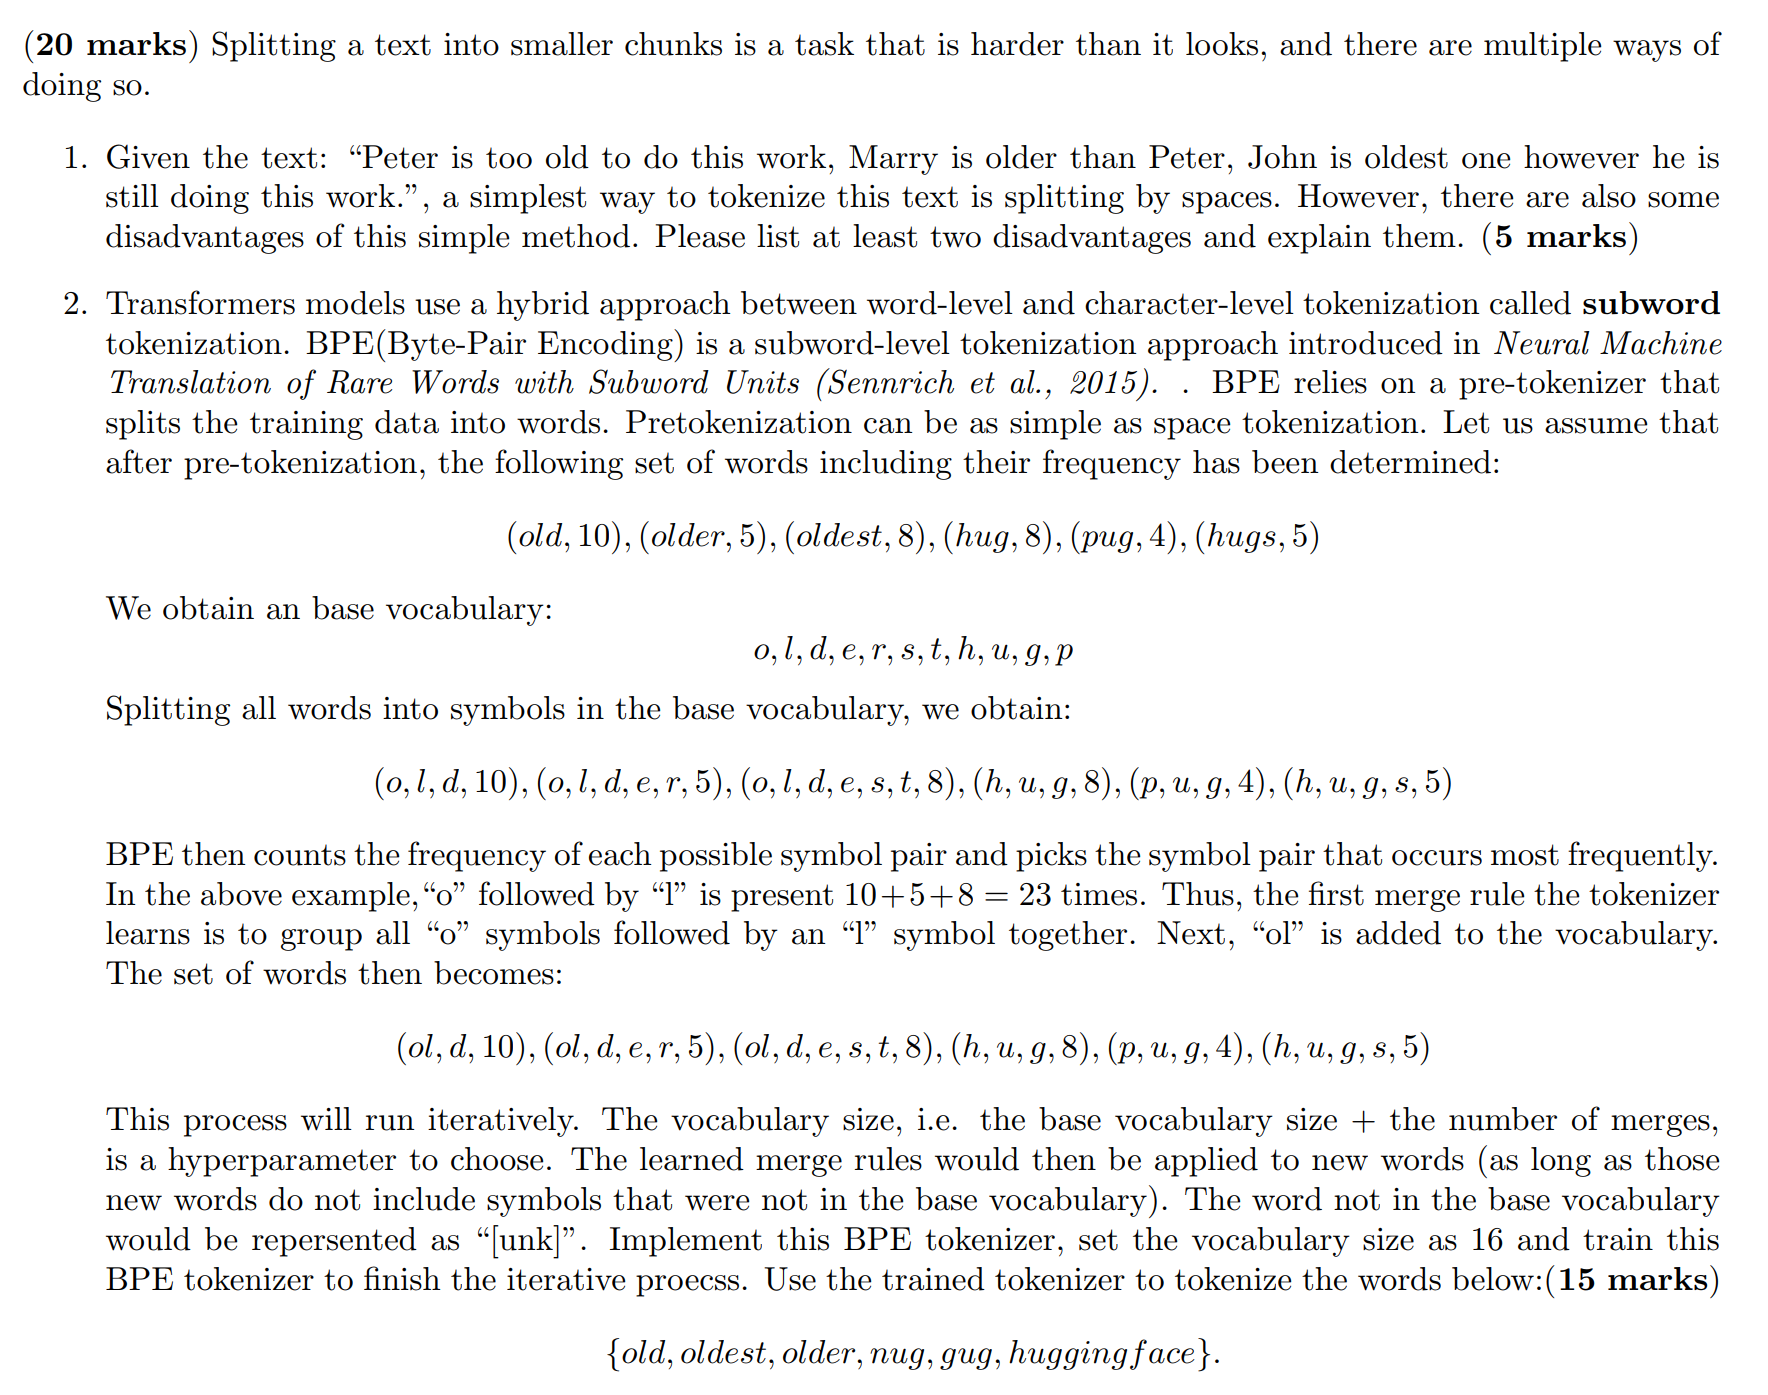

## (1)

**answer**  
- **unnecessary training**: one word can have different forms, there is no need to train them all seperately. eg. old, older, oldest  
- **computational cost**: word-level tokenization will need to construct a huge vocabulary dictionary, while chracter-level tokenization only need 26.  
- **sparsity problem**: low frequency words can not be learnt effectively

## (2)

In [277]:
import re
from operator import itemgetter


vocab = {
    'o l d </w>': 10,
    'o l d e r </w>': 5,
    'o l d e s t </w>': 8,
    'h u g </w>': 8,
    'p u g </w>': 4,
    'h u g s </w>': 5
}


def get_pair_stats(vocab):
    pairs = {}
    for word, frequency in vocab.items():
        symbols = word.split()

        # count occurrences of pairs
        for i in range(len(symbols) - 1):
            pair = (symbols[i], symbols[i + 1])
            current_frequency = pairs.get(pair, 0)
            pairs[pair] = current_frequency + frequency

    return pairs

def merge_vocab(best_pair,vocab_in):
    vocab_out = {}
    pattern = re.escape(' '.join(best_pair))
    replacement = ''.join(best_pair)

    for word_in in vocab_in:
        # replace most frequent pair in all vocabulary
        word_out = re.sub(pattern, replacement, word_in)
        vocab_out[word_out] = vocab_in[word_in]

    return vocab_out



bpe_codes = {}
vocab_size = 16
base_vocab_size = len(vocab)
num_merges = vocab_size - base_vocab_size

for i in range(num_merges):
#     print('\niteration', i)
    pair_stats = get_pair_stats(vocab)
    if not pair_stats:
        break

    best_pair = max(pair_stats, key=pair_stats.get)
    bpe_codes[best_pair] = i

#     print('vocabulary: ', vocab)
#     print('best pair:', best_pair)
    vocab = merge_vocab(best_pair, vocab)

# print('\nfinal vocabulary: ', vocab)
# print('\nbyte pair encoding: ', bpe_codes)



def get_pairs(word):
    pairs = set()
    prev_char = word[0]
    for char in word[1:]:
        pairs.add((prev_char, char))
        prev_char = char

    return pairs

def create_new_word(word, pair_to_merge):
    first, second = pair_to_merge
    new_word = []
    i = 0
    while i < len(word):
        try:
            j = word.index(first, i)
            new_word.extend(word[i:j])
            i = j
        except ValueError:
            new_word.extend(word[i:])
            break

        if i < len(word) - 1 and word[i + 1] == second:
            new_word.append(first + second)
            i += 2
        else:
            new_word.append(first)
            i += 1

    return new_word

def encode(original_word, bpe_codes):
    if len(original_word) == 1:
        return original_word

    word = list(original_word)
    word.append('</w>')

    while True:
        pairs = get_pairs(word)
        bpe_codes_pairs = [(pair, bpe_codes[pair]) for pair in pairs if pair in bpe_codes]
        if not bpe_codes_pairs:
            break

        pair_to_merge = min(bpe_codes_pairs, key=itemgetter(1))[0]
        word = create_new_word(word, pair_to_merge)

    return word



original_word = ['old','oldest','older','nug','gug', 'huggingface']

for i in original_word:
    print("original word:",i,",encoded word",encode(i, bpe_codes))   

original word: old ,encoded word ['old</w>']

original word: oldest ,encoded word ['oldest</w>']

original word: older ,encoded word ['olde', 'r', '</w>']

original word: nug ,encoded word ['n', 'ug', '</w>']

original word: gug ,encoded word ['g', 'ug', '</w>']

original word: huggingface ,encoded word ['hug', 'g', 'i', 'n', 'g', 'f', 'a', 'c', 'e', '</w>']

